# Topic modelling

In this notebook, we perform a topic modelling analysis of COVID-19 publications.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, json, pickle
import pandas as pd
import numpy as np

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 2.5})

In [2]:
df_meta = pd.read_csv("data/df_meta.csv",compression="gzip")
df_joined_all = pd.read_csv("data/df_joined_all.csv", compression="gzip")

In [3]:
df_meta.head()

,pub_id,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,pmid,pmcid,dimensions_id,arxiv_id,timestamp,lang
0,0,Coronavirus disease 2019 (COVID-19) and simult...,Coronavirus disease 2019 (COVID-19) is a recen...,2020.0,5.0,CardioVascular Journal of Africa,31,NaN,1-4,10-5830-cvja-2020-016,32490506.0,NaN,pub.1128171889,NaN,2020-07-02 10:54:27.347501,en
1,1,[Ten hot issues of breast cancer under the nov...,NaN,2020.0,2.0,Chinese medical journal,100,0,e002,10.0376/cma.j.issn.0376-2491.2020.0002,32036640.0,NaN,pub.1124777091,NaN,2020-07-02 10:54:27.347501,en
2,2,Cohesion in Distancing.,"In isolation, we are physically apart; in soli...",2020.0,4.0,The AMA Journal of Ethic,22,4,e344-345,10.1001/amajethics.2020.344,32345430.0,NaN,pub.1127182341,NaN,2020-07-02 10:54:27.347501,en
3,3,Salvation in a Time of Plague.,Health workers offer their skills and care to ...,2020.0,5.0,The AMA Journal of Ethic,22,5,e441-445,10.1001/amajethics.2020.441,32449663.0,NaN,pub.1127905371,NaN,2020-07-02 10:54:27.347501,en
4,4,What Should Health Science Journalists Do in E...,Journalists have long covered outbreaks of inf...,2020.0,1.0,AMA journal of ethics,NaN,NaN,NaN,10.1001/amajethics.2020.55,31958392.0,NaN,NaN,NaN,2020-07-02 10:54:27.347501,en


In [4]:
df_meta.columns

Index(['pub_id', 'title', 'abstract', 'publication_year', 'publication_month',
       'journal', 'volume', 'issue', 'pages', 'doi', 'pmid', 'pmcid',
       'dimensions_id', 'arxiv_id', 'timestamp', 'lang'],
      dtype='object')

## Text analysis

In [5]:
# concatenate abstracts and titles

df_meta["title"] = df_meta["title"].fillna('')
df_meta["abstract"] = df_meta["abstract"].fillna('')
df_meta["title_abstract"] = df_meta.title +" "+df_meta.abstract

In [6]:
# note that ~33k articles have no abstract
df_meta[(df_meta["abstract"]=="")&(df_meta.lang=="en")].shape[0]

33301

In [161]:
df_meta[(df_meta["abstract"]!="")&(df_meta.lang=="en")].shape[0]

118946

In [162]:
df_joined_all[df_joined_all["in_wikipedia"]==True].shape

(3083, 39)

In [7]:
# we focus on English

In [8]:
# coverage in Wikipedia of English or not

print("English:",df_joined_all[(df_joined_all["lang"]=='en') & (df_joined_all["in_wikipedia"]==True)].shape[0]/df_meta[df_meta["lang"]=='en'].shape[0])
print("Non English:",df_joined_all[(df_joined_all["lang"]!='en') & (df_joined_all["in_wikipedia"]==True)].shape[0]/df_meta[df_meta["lang"]!='en'].shape[0])

English: 0.02011862302705472
Non English: 0.0023784040908550364


In [9]:
# coverage of non English sources is ~10 times lower

In [10]:
texts = df_meta[df_meta["lang"]=='en'].title_abstract.tolist()

In [11]:
df_meta.shape

(160656, 17)

In [12]:
len(texts)

152247

#### Topic modelling

In [13]:
from tqdm import tqdm
import gensim, sklearn
import scispacy
import spacy
import pyLDAvis.gensim

In [158]:
#!python -m spacy download en

In [15]:
#nlp = spacy.load('en')
nlp = spacy.load("en_core_sci_md")
#STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

In [16]:
%%time

# pre-processing: use lemmas and remove stopwords, add entities

processed_docs = list()
for doc in nlp.pipe(texts, n_process=6, batch_size=100):

    ents = doc.ents  # Named entities

    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop and len(token) > 1]# token.is_alpha]

    # Add named entities, but only if they are a compound of more than one word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])
                        
    processed_docs.append(doc)

CPU times: user 16min 52s, sys: 1min 7s, total: 17min 59s
Wall time: 20min 40s


In [17]:
import pickle

pickle.dump(processed_docs, open("data/processed_docs_scispacy_july.pk", "wb"))

In [14]:
import pickle

processed_docs = pickle.load(open("data/processed_docs_scispacy_july.pk", "rb"))

In [18]:
docs = processed_docs
del processed_docs

# Add bigrams
from gensim.models.phrases import Phrases
# Add bigrams to docs (only ones that appear several times or more).
bigram = Phrases(docs, min_count=100)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [19]:
texts[0]

'Coronavirus disease 2019 (COVID-19) and simultaneous acute anteroseptal and inferior ST-segment elevation myocardial infarction. Coronavirus disease 2019 (COVID-19) is a recently recognised pandemic spreading rapidly from Wuhan, Hubei, to other provinces in China and to many countries around the world. The number of COVID-19-related deaths is steadily increasing. Acute ST-segment elevation myocardial infarction (STEMI) is a disease with high morbidity and mortality rates, and primary percutaneous coronary intervention is usually recommended for the treatment. A patient with diabetes mellitus and hypertension for five years was admitted to the emergency unit with symptoms of fever, cough and dyspnoea. These symptoms were consistent with viral pneumonia and a COVID PCR test was performed, which tested positive three days later. The patient had chest pain on the eighth day of hospitalisation. On electrocardiography, simultaneous acute inferior and anterior STEMI were identified. High lev

In [20]:
" ".join(docs[0])

'coronavirus disease 2019 covid-19 simultaneous acute anteroseptal inferior st-segment elevation myocardial infarction coronavirus disease 2019 covid-19 recently recognise pandemic spreading rapidly Wuhan Hubei province China country world number covid-19-related death steadily increase acute st-segment elevation myocardial infarction stemi disease high morbidity mortality rate primary percutaneous coronary intervention usually recommend treatment patient diabetes mellitus hypertension year admit emergency unit symptom fever cough dyspnoea symptom consistent viral pneumonia covid pcr test perform test positive day later patient chest pain eighth day hospitalisation electrocardiography simultaneous acute inferior anterior STEMI identify high level stress increase metabolic demand patient lead concomitant thrombosis different coronary artery present different stemi Coronavirus disease 2019 acute anteroseptal inferior ST-segment elevation myocardial infarction Coronavirus disease 2019 COV

In [21]:
# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
# Admittedly, values are arbitrary here.
max_freq = 0.5
min_wordcount = 10

In [22]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of docs: %d (%d)' % (len(corpus),len(texts)))

Number of unique tokens: 63406
Number of docs: 152247 (152247)


In [23]:
dictionary.token2id["covid-19"]

28

In [24]:
from collections import Counter

c = Counter()

for d in docs:
    c.update(d)

In [25]:
# most common words in the corpus, by frequency

c.most_common(min_wordcount)

[('patient', 155480),
 ('study', 101393),
 ('virus', 101323),
 ('infection', 85576),
 ('disease', 78549),
 ('result', 75709),
 ('covid-19', 67713),
 ('cell', 61601),
 ('case', 56625),
 ('respiratory', 53841)]

## Correlated Topic Model

In [26]:
import tomotopy as tp

# CTM model with 15 topics, removal of words appearing in fewer than 0.5% of the documents, minimum word count but no trimming from above on frequent words
params = {'num_topics': 15, 'min_cf': 100, 'min_df': int(len(docs)*0.005), 'rm_top': 0, 'random_state': seed}
mdl = tp.CTModel(k=params['num_topics'],min_cf=params['min_cf'],min_df=params['min_df'],seed=params['random_state'],rm_top=params['rm_top'])
#mdl = tp.HDPModel(min_cf=params['min_cf'],min_df=params['min_df'],seed=params['random_state'])
for doc in docs:
    mdl.add_doc(doc)

for i in range(0, 201, 10):
    mdl.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))

Iteration: 0	Log-likelihood: -7.529966658151058
Iteration: 10	Log-likelihood: -7.366427118093857
Iteration: 20	Log-likelihood: -7.209213647876499
Iteration: 30	Log-likelihood: -6.964955393674733
Iteration: 40	Log-likelihood: -6.670141444126636
Iteration: 50	Log-likelihood: -6.423878499095991
Iteration: 60	Log-likelihood: -6.266209110873064
Iteration: 70	Log-likelihood: -6.196157004786949
Iteration: 80	Log-likelihood: -6.146757594200305
Iteration: 90	Log-likelihood: -6.0995396208172385
Iteration: 100	Log-likelihood: -6.053723535078817
Iteration: 110	Log-likelihood: -6.017252752595261
Iteration: 120	Log-likelihood: -5.988275788869664
Iteration: 130	Log-likelihood: -5.9740272240771874
Iteration: 140	Log-likelihood: -5.948368045267465
Iteration: 150	Log-likelihood: -5.933038198935017
Iteration: 160	Log-likelihood: -5.9248024720224794
Iteration: 170	Log-likelihood: -5.926037883803881
Iteration: 180	Log-likelihood: -5.926420672986073
Iteration: 190	Log-likelihood: -5.9319597617761435
Iterati

In [46]:
for k in range(mdl.k):
    print('Top 10 words of topic #{}'.format(k))
    print(mdl.get_topic_words(k, top_n=20))

Top 10 words of topic #0
[('respiratory', 0.0820087268948555), ('infection', 0.0677209123969078), ('influenza', 0.03698534891009331), ('sars-cov-2', 0.03519709035754204), ('acute', 0.033565718680620193), ('test', 0.03250555694103241), ('sample', 0.03195415064692497), ('severe', 0.03089703433215618), ('syndrome', 0.03003336861729622), ('detect', 0.028685318306088448), ('detection', 0.025124026462435722), ('positive', 0.025053957477211952), ('assay', 0.019140813499689102), ('respiratory_syndrome', 0.017710508778691292), ('severe_acute', 0.016296958550810814), ('diagnostic', 0.01539673563092947), ('testing', 0.013836956582963467), ('laboratory', 0.012691494077444077), ('pcr', 0.011593252420425415), ('illness', 0.011535369791090488)]
Top 10 words of topic #1
[('model', 0.047360435128211975), ('system', 0.03642703592777252), ('new', 0.028110340237617493), ('approach', 0.02547319419682026), ('research', 0.02041775919497013), ('provide', 0.017501626163721085), ('challenge', 0.0163568183779716

In [141]:
topic_labels = {
    "Coronaviruses": [0,6],
    "Epidemics": [1,7,10],
    "Public health": [4,5,14],
    "Molecular biology and immunology": [8,11,13],
    "Clinical medicine": [2,3,9,12]
}

In [126]:
# printout for LaTeX

#for k in range(mdl.k):
#    print("\\item \\textbf{Topic \\#%d}"%k+": "+"``"+"'', ``".join([w[0] for w in mdl.get_topic_words(k, top_n=30) if len(w[0])>2])+"''.")

In [127]:
# topics over time

df_local = df_meta[(df_meta["lang"]=='en') & (pd.notnull(df_meta["title_abstract"]))]
publication_years = df_local.publication_year.tolist()
dois = df_local.doi.tolist()
pids = df_local.pub_id.tolist()
titles = df_local.title.tolist()
topics_corr = np.zeros((len(docs),params['num_topics']))

for n,doc in enumerate(mdl.docs):
    for m,t in enumerate(doc.get_topic_dist()):
        topics_corr[n][m] = t

In [128]:
df_topics_corr = pd.DataFrame(topics_corr)

In [129]:
df_topics_corr["year"] = publication_years
df_topics_corr["doi"] = dois

In [130]:
from_which_year = 1980

grouped_corr = df_topics_corr.groupby('year')
df_grouped_corr = grouped_corr.aggregate(np.mean)
df_grouped_corr = df_grouped_corr[df_grouped_corr.index >= from_which_year]
#df_grouped

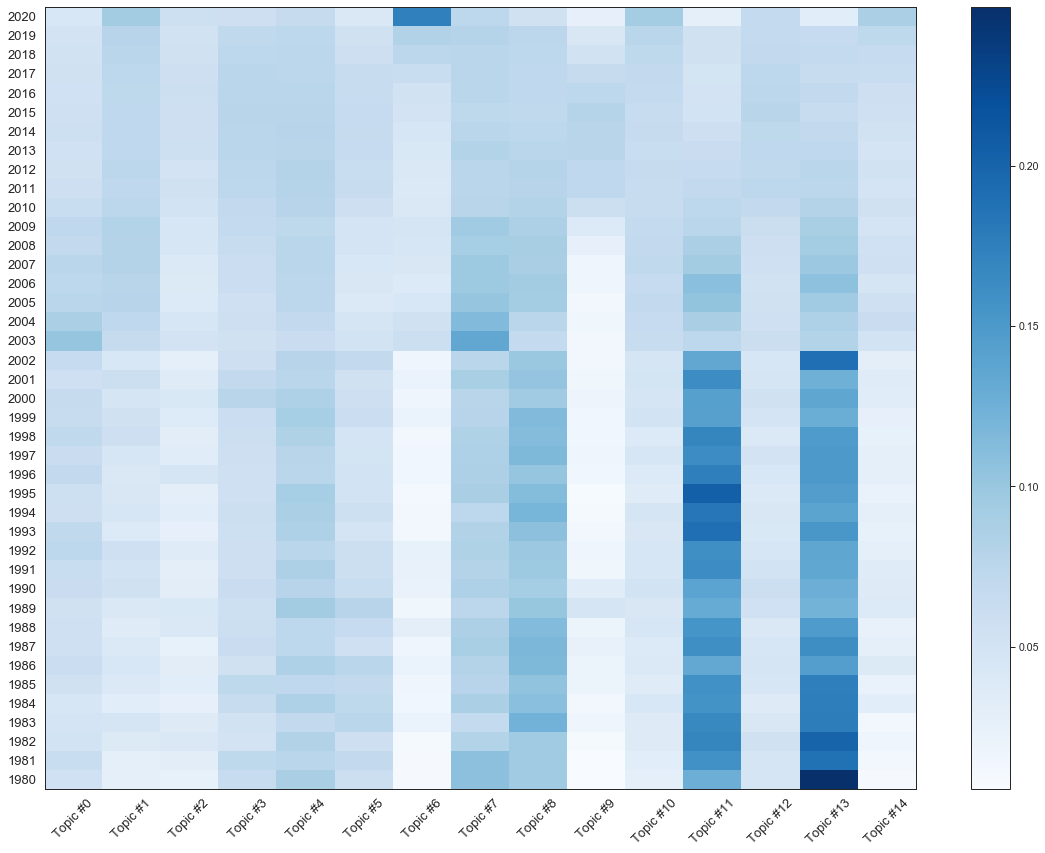

In [131]:
fig = plt.figure(figsize=(16, 12))
plt.pcolor(df_grouped_corr.to_numpy(), norm=None, cmap='Blues')
plt.yticks(np.arange(df_grouped_corr.to_numpy().shape[0])+0.5, [int(x) for x in df_grouped_corr.index.values])
plt.xticks(np.arange(df_grouped_corr.to_numpy().shape[1])+0.5, ["Topic #"+str(n) for n in range(mdl.k)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tick_params(labelsize=13)
plt.tight_layout()  # fixes margins
plt.savefig("figures/corr_topic_model_all_time_15_ctm.pdf")
plt.show()

In [132]:
# topic correlations

topics_correlations = np.zeros((mdl.k,mdl.k))

for k in range(mdl.k):
    for m,c in enumerate(mdl.get_correlations(k)):
        topics_correlations[k][m] = c

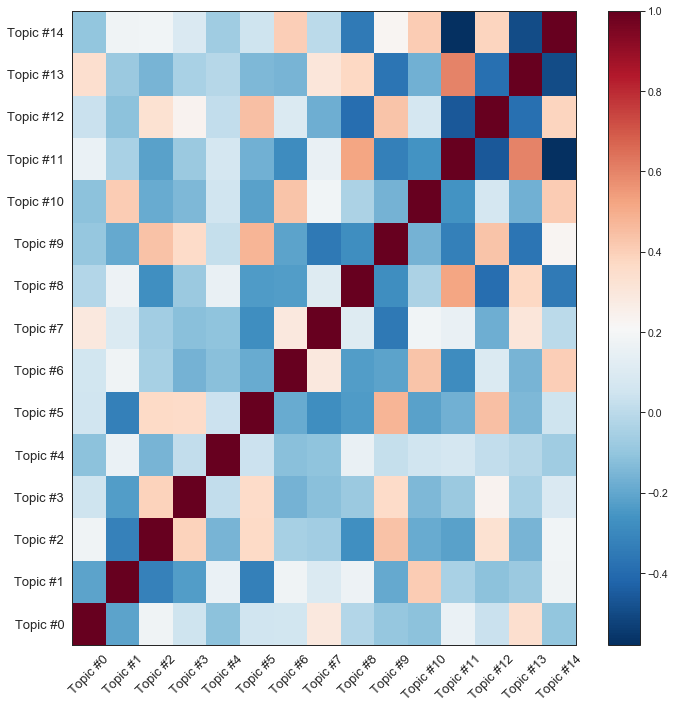

In [133]:
fig = plt.figure(figsize=(10, 10))
plt.pcolor(topics_correlations, norm=None, cmap='RdBu_r')
plt.yticks(np.arange(mdl.k)+0.5, ["Topic #"+str(n) for n in range(mdl.k)])
plt.xticks(np.arange(mdl.k)+0.5, ["Topic #"+str(n) for n in range(mdl.k)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tick_params(labelsize=13)
plt.tight_layout()  # fixes margins
plt.savefig("figures/corr_topic_model_correlations_15_ctm.pdf")

In [134]:
# calculate topic distances
from scipy.spatial.distance import cosine, euclidean, jensenshannon

topics_distances = np.zeros((mdl.k,mdl.k))
threshold = 1.0e-05 # apply a threshold on low prob words per topic

for k in range(mdl.k):
    for m in range(mdl.k)[k+1:]:
        d1 = np.array(mdl.get_topic_word_dist(k))
        d2 = np.array(mdl.get_topic_word_dist(m))
        ab_t = d1 < threshold
        d1[ab_t] = 0
        ab_t = d2 < threshold
        d2[ab_t] = 0
        d = jensenshannon(d1,d2)
        topics_distances[k][m] = d
        topics_distances[m][k] = d

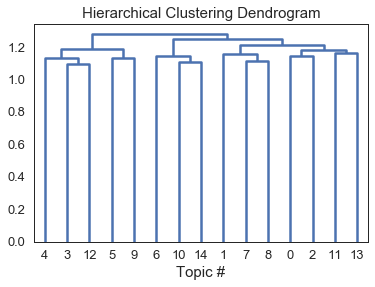

In [135]:
# From: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model_hc = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model_hc = model_hc.fit(topics_distances)
plt.title('Hierarchical Clustering Dendrogram', fontsize=15)
# plot the top three levels of the dendrogram
plot_dendrogram(model_hc, truncate_mode='level', p=10)
plt.xlabel("Topic #", fontsize=15)
plt.tick_params(labelsize=13)
plt.savefig("figures/nb2_dendrogram_ctm.pdf")

#### Macrotopic analysis

In [142]:
# get number of papers per macro topic over time

is_selected_topic = {t:[0 for _ in range(len(docs))] for t in topic_labels.keys()}
topic_to_label = dict()
for k,v in topic_labels.items():
    for vv in v:
        topic_to_label[vv] = k
        
for n,doc in enumerate(mdl.docs):
    for m,t in enumerate(doc.get_topic_dist()):
        is_selected_topic[topic_to_label[m]][n] += t

In [143]:
# plot trends

df_topic_intensity = pd.DataFrame.from_dict(is_selected_topic)
df_topic_intensity["year"] = publication_years
df_topic_intensity["doi"] = dois
df_topic_intensity["pub_id"] = pids
df_topic_intensity["title"] = titles

In [144]:
from_which_year = 2000

grouped_ti = df_topic_intensity.groupby('year')
df_grouped_ti_m = grouped_ti.aggregate(np.mean)
df_grouped_ti_s = grouped_ti.aggregate(np.sum)
df_grouped_ti_m = df_grouped_ti_m[df_grouped_ti_m.index >= from_which_year]
df_grouped_ti_s = df_grouped_ti_s[df_grouped_ti_s.index >= from_which_year]

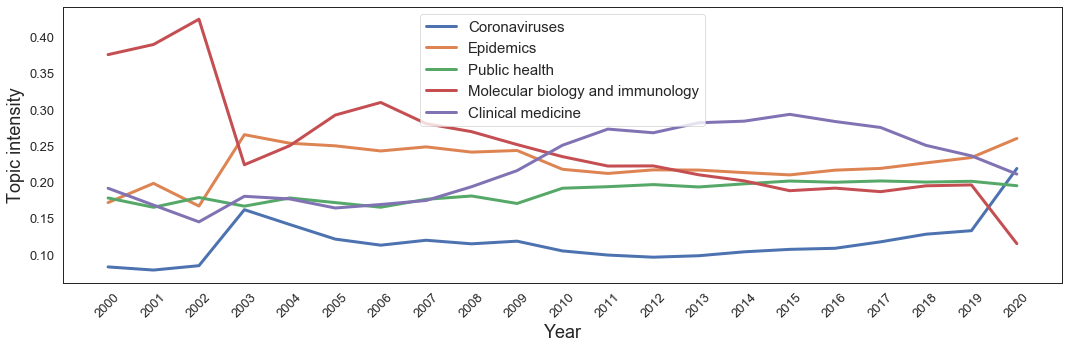

In [145]:
fig = plt.figure(figsize=(15, 5))
for k in topic_labels.keys():
    plt.plot(df_grouped_ti_m[k].values, label="%s"%k, linewidth=3)
plt.xticks(np.arange(df_grouped_ti_m.shape[0]), [int(x) for x in df_grouped_ti_m.index.values], rotation=45)
plt.legend(loc="upper center",fontsize=15)
plt.ylabel("Topic intensity",fontsize=18)
plt.xlabel("Year",fontsize=18)
plt.tick_params(labelsize=13)
plt.tight_layout()  # fixes margins
plt.savefig("figures/nb2_topic_model_trends_mean_ctm.pdf")

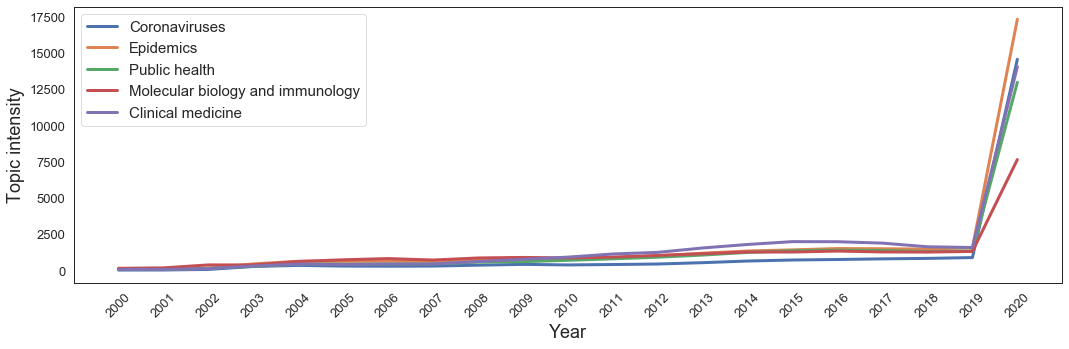

In [146]:
fig = plt.figure(figsize=(15, 5))
for k in topic_labels.keys():
    plt.plot(df_grouped_ti_s[k].values, label="%s"%k, linewidth=3)
plt.xticks(np.arange(df_grouped_ti_s.shape[0]), [int(x) for x in df_grouped_ti_s.index.values], rotation=45)
plt.legend(loc="upper left",fontsize=15)
plt.ylabel("Topic intensity",fontsize=18)
plt.xlabel("Year",fontsize=18)
plt.tick_params(labelsize=13)
plt.tight_layout()  # fixes margins
plt.savefig("figures/nb2_topic_model_trends_sum_ctm.pdf")

In [147]:
# does it work?

df_topic_intensity.sort_values("Coronaviruses", ascending=False).head(10)

,Coronaviruses,Epidemics,Public health,Molecular biology and immunology,Clinical medicine,year,doi,pub_id,title
56072,1.0,0.0,0.0,0.0,0.0,2020.0,10.1016/s2213-2198(20)30199-9,60854,Practice Notes from the AAAI
98383,1.0,0.0,0.0,0.0,0.0,2020.0,10.1177/0141076820925778,104288,Anatomising failure: there should be a statuto...
29443,1.0,0.0,0.0,0.0,0.0,2020.0,10.1016/j.anai.2020.05.031,32319,Review: Shared Decision-Making in the Care of ...
124940,1.0,0.0,0.0,0.0,0.0,2020.0,10.3145/epi.2020.mar.16,132002,"Retweeting Covid-19 disability issues: Risks, ..."
90104,1.0,0.0,0.0,0.0,0.0,2020.0,10.1126/sciadv.abc2800,95836,Medicine in the time of corona: Fundamental mo...
69643,1.0,0.0,0.0,0.0,0.0,2020.0,10.1093/cid/ciaa409,74993,Predictors of refractory Coronavirus disease (...
106900,1.0,0.0,0.0,0.0,0.0,2020.0,10.1213/ane.0000000000004930,112904,Return to Normal: Prioritizing Elective Surger...
125718,1.0,0.0,0.0,0.0,0.0,2003.0,10.3201/eid0906.030283,132822,Control Measures for Severe Acute Respiratory ...
90197,1.0,0.0,0.0,0.0,0.0,2020.0,10.1126/science.367.6483.1207-o,95937,Cancer drivers converge on NOTCH
105769,1.0,0.0,0.0,0.0,0.0,2020.0,10.1186/s40249-020-00646-x,111735,"Epidemiology, causes, clinical manifestation a..."


In [148]:
# save data frame, drop Background topics

df_topic_intensity.drop(columns=["title","doi","year"], inplace=True)
df_topic_intensity.rename(columns={"Coronaviruses": "tm_coronaviruses",
    "Epidemics": "tm_epidemics",
    "Public health": "tm_ph",
    "Molecular biology and immunology": "tm_mbi",
    "Clinical medicine": "tm_clinical_medicine"}, inplace=True)
df_topic_intensity.to_csv("data/df_topic_intensity_ctm.csv", compression="gzip", index=False)

## LDA

In [65]:
%%time

from gensim.models import LdaMulticore, LdaModel
params = {'num_topics': 15,'passes': 10, 'random_state': seed}
model = LdaModel(corpus=corpus, num_topics=params['num_topics'], id2word=dictionary, #workers=6,
                passes=params['passes'], random_state=params['random_state'])

CPU times: user 16min 56s, sys: 8.04 s, total: 17min 4s
Wall time: 18min 58s


In [78]:
model.show_topics(num_words=30, num_topics=params['num_topics'])

[(0,
  '0.015*"method" + 0.014*"system" + 0.012*"use" + 0.009*"drug" + 0.009*"application" + 0.008*"approach" + 0.008*"image" + 0.008*"design" + 0.008*"test" + 0.007*"develop" + 0.006*"technology" + 0.006*"provide" + 0.006*"technique" + 0.006*"new" + 0.005*"tool" + 0.005*"potential" + 0.005*"base" + 0.005*"device" + 0.005*"allow" + 0.004*"result" + 0.004*"development" + 0.004*"performance" + 0.004*"target" + 0.004*"testing" + 0.004*"detection" + 0.004*"machine" + 0.004*"available" + 0.004*"screening" + 0.004*"novel" + 0.004*"solution"'),
 (1,
  '0.019*"health" + 0.017*"pandemic" + 0.014*"covid-19" + 0.010*"COVID-19" + 0.010*"public" + 0.009*"country" + 0.008*"outbreak" + 0.007*"social" + 0.007*"care" + 0.006*"covid-19_pandemic" + 0.005*"measure" + 0.005*"policy" + 0.005*"people" + 0.005*"public_health" + 0.005*"Health" + 0.005*"impact" + 0.005*"response" + 0.005*"risk" + 0.004*"medical" + 0.004*"need" + 0.004*"system" + 0.004*"lockdown" + 0.004*"healthcare" + 0.004*"global" + 0.004*"co

In [160]:
# printout for LaTeX
#for t in model.show_topics(num_words=20, num_topics=params['num_topics'], formatted=False):
#    print("\\item \\textbf{Topic \\#%d}"%t[0]+": "+"``"+"'', ``".join([w[0] for w in t[1] if len(w[0])>2])+"''.")

In [68]:
# plot topics (NOTE: the IDs here do not match those from the model)
data =  pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

In [69]:
# topics over time

df_local = df_meta[(df_meta["lang"]=='en') & (pd.notnull(df_meta["title_abstract"]))]
publication_years = df_local.publication_year.tolist()
dois = df_local.doi.tolist()
pids = df_local.pub_id.tolist()
titles = df_local.title.tolist()
topics = np.zeros((len(docs),params['num_topics']))

for n,doc_topics in enumerate(model.get_document_topics(corpus)):
    for t in doc_topics:
        topics[n][t[0]] = t[1]

In [70]:
topics[0,:]

array([0.        , 0.11178236, 0.        , 0.        , 0.        ,
       0.09960542, 0.        , 0.        , 0.23566544, 0.        ,
       0.        , 0.        , 0.0911274 , 0.01608227, 0.44118416])

In [71]:
model.get_document_topics(corpus[0])

[(1, 0.111787245),
 (5, 0.09959995),
 (8, 0.23566486),
 (12, 0.09112751),
 (13, 0.016082505),
 (14, 0.441185)]

In [72]:
df_topics = pd.DataFrame(topics)

In [73]:
df_topics["year"] = publication_years
df_topics["doi"] = dois

In [74]:
from_which_year = 1980

grouped = df_topics.groupby('year')
df_grouped = grouped.aggregate(np.mean)
df_grouped = df_grouped[df_grouped.index >= from_which_year]

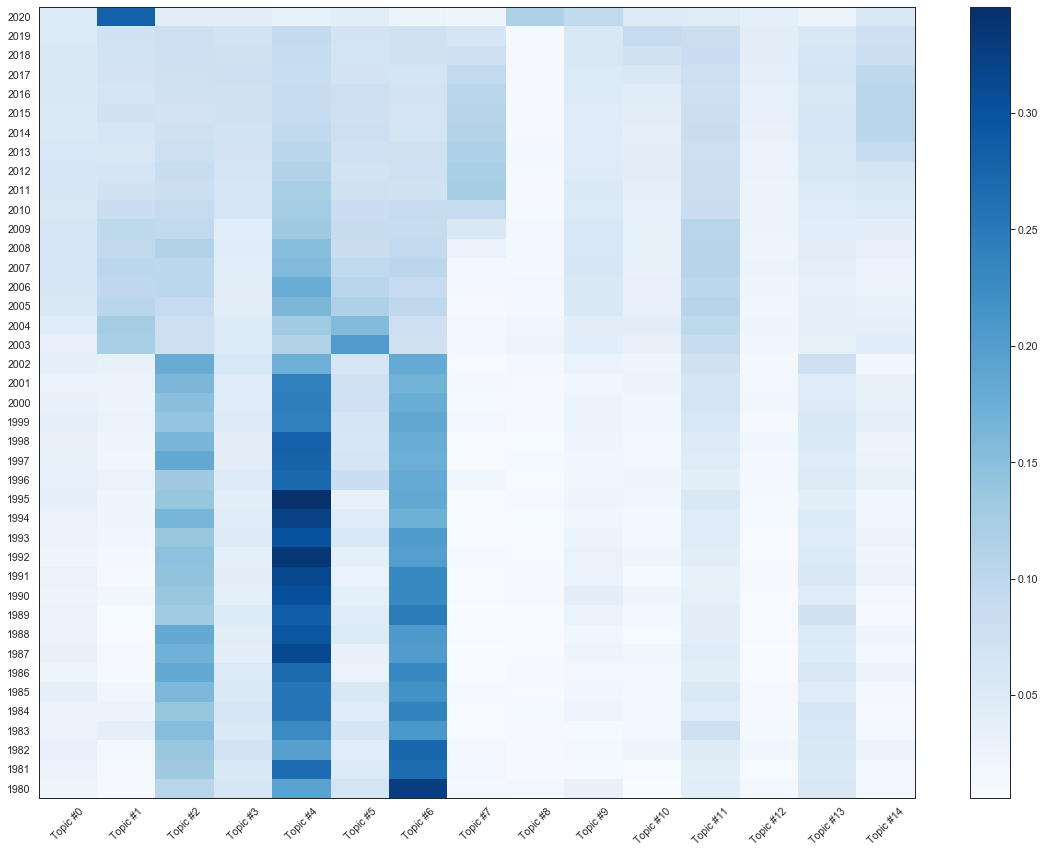

In [75]:
fig = plt.figure(figsize=(16, 12))
plt.pcolor(df_grouped.to_numpy(), norm=None, cmap='Blues')
plt.yticks(np.arange(df_grouped.to_numpy().shape[0])+0.5, [int(x) for x in df_grouped.index.values])
plt.xticks(np.arange(df_grouped.to_numpy().shape[1])+0.5, ["Topic #"+str(n) for n in range(model.num_topics)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
plt.savefig("figures/nb2_topic_model_all_time_15.pdf")
plt.show()

In [76]:
# calculate topic distances
from scipy.spatial.distance import cosine, euclidean, jensenshannon

topics_distances = np.zeros((params['num_topics'],params['num_topics']))
topics_terms = model.state.get_lambda()

for k in range(params['num_topics']):
    for m in range(params['num_topics'])[k+1:]:
        d = jensenshannon(topics_terms[k,:],topics_terms[m,:])
        topics_distances[k][m] = d
        topics_distances[m][k] = d

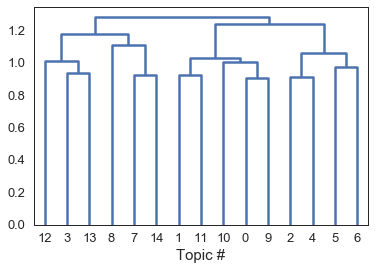

In [77]:
# From: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model_hc = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model_hc = model_hc.fit(topics_distances)
#plt.title('Hierarchical Clustering Dendrogram', fontsize=15)
# plot the top three levels of the dendrogram
plot_dendrogram(model_hc, truncate_mode='level', p=10)
plt.xlabel("Topic #", fontsize=15)
plt.tick_params(labelsize=13)
plt.savefig("figures/nb2_dendrogram.pdf")

#### Macrotopic analysis

In [149]:
# define macro topics

topic_labels = {
    "Coronaviruses": [5,8],
    "Epidemics": [9,11,12],
    "Public health": [0,1,10],
    "Molecular biology and immunology": [2,4,6],
    "Clinical medicine": [3,7,13,14]
}

In [150]:
# get number of papers per macro topic over time

is_selected_topic = {t:[0 for _ in range(len(docs))] for t in topic_labels.keys()}
topic_to_label = dict()
for k,v in topic_labels.items():
    for vv in v:
        topic_to_label[vv] = k
for d in range(len(docs)):
    d_topics = model.get_document_topics(corpus[d])
    for x in d_topics:
        is_selected_topic[topic_to_label[x[0]]][d] += x[1]

In [151]:
# plot trends

df_topic_intensity = pd.DataFrame.from_dict(is_selected_topic)
df_topic_intensity["year"] = publication_years
df_topic_intensity["doi"] = dois
df_topic_intensity["pub_id"] = pids
df_topic_intensity["title"] = titles

In [152]:
from_which_year = 2000

grouped_ti = df_topic_intensity.groupby('year')
df_grouped_ti_m = grouped_ti.aggregate(np.mean)
df_grouped_ti_s = grouped_ti.aggregate(np.sum)
df_grouped_ti_m = df_grouped_ti_m[df_grouped_ti_m.index >= from_which_year]
df_grouped_ti_s = df_grouped_ti_s[df_grouped_ti_s.index >= from_which_year]

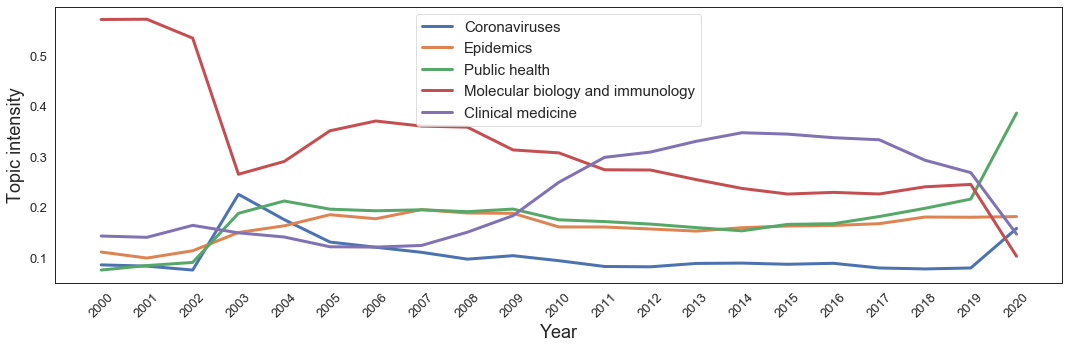

In [153]:
fig = plt.figure(figsize=(15, 5))
for k in topic_labels.keys():
    plt.plot(df_grouped_ti_m[k].values, label="%s"%k, linewidth=3)
plt.xticks(np.arange(df_grouped_ti_m.shape[0]), [int(x) for x in df_grouped_ti_m.index.values], rotation=45)
plt.legend(loc="upper center",fontsize=15)
plt.ylabel("Topic intensity",fontsize=18)
plt.xlabel("Year",fontsize=18)
plt.tick_params(labelsize=13)
plt.tight_layout()  # fixes margins
plt.savefig("figures/nb2_topic_model_trends_mean.pdf")

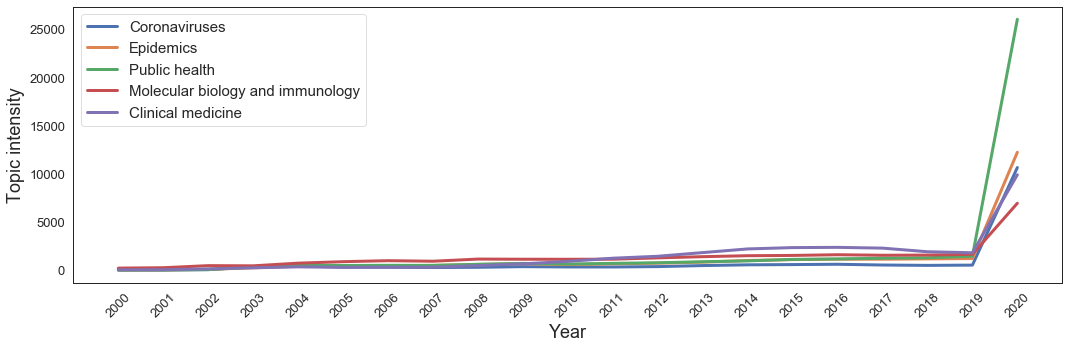

In [154]:
fig = plt.figure(figsize=(15, 5))
for k in topic_labels.keys():
    plt.plot(df_grouped_ti_s[k].values, label="%s"%k, linewidth=3)
plt.xticks(np.arange(df_grouped_ti_s.shape[0]), [int(x) for x in df_grouped_ti_s.index.values], rotation=45)
plt.legend(loc="upper left",fontsize=15)
plt.ylabel("Topic intensity",fontsize=18)
plt.xlabel("Year",fontsize=18)
plt.tick_params(labelsize=13)
plt.tight_layout()  # fixes margins
plt.savefig("figures/nb2_topic_model_trends_sum.pdf")

In [156]:
# does it work?

df_topic_intensity.sort_values("Epidemics", ascending=False).head()

,Coronaviruses,Epidemics,Public health,Molecular biology and immunology,Clinical medicine,year,doi,pub_id,title
143752,0.0,0.992951,0.0,0.0,0.0,2007.0,NaN,152029,Modelling disease spread and control in networ...
20956,0.0,0.989920,0.0,0.0,0.0,2015.0,10.1007/s11704-014-3369-2,22498,Mathematical and computational approaches to e...
7756,0.0,0.989607,0.0,0.0,0.0,2020.0,10.1007/978-3-030-45439-5_22,8032,Inductive Document Network Embedding with Topi...
151636,0.0,0.986433,0.0,0.0,0.0,2020.0,NaN,160045,Pixelate to communicate: visualising uncertain...
45305,0.0,0.986272,0.0,0.0,0.0,2014.0,10.1016/j.mpmed.2013.10.014,48892,Emerging infectious diseases


In [157]:
# save data frame

df_topic_intensity.drop(columns=["title","doi","year"], inplace=True)
df_topic_intensity.rename(columns={"Coronaviruses": "tm_coronaviruses",
    "Epidemics": "tm_epidemics",
    "Public health": "tm_ph",
    "Molecular biology and immunology": "tm_mbi",
    "Clinical medicine": "tm_clinical_medicine"}, inplace=True)
df_topic_intensity.to_csv("data/df_topic_intensity.csv", compression="gzip", index=False)

### Support sections

##### Number of topics

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics.
    From: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    params = {'passes': 3, 'random_state': seed}
    for num_topics in range(start, limit, step):
        m = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,# workers=6,
                passes=params['passes'], random_state=params['random_state'])
        model_list.append(m)
        coherencemodel = CoherenceModel(model=m, texts=docs, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run
limit=50; start=5; step=5;
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=start, limit=limit, step=step)

In [ ]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.pcolor(topics_correlations, norm=None, cmap='RdBu_r')
plt.yticks(np.arange(mdl.k)+0.5, ["Topic #"+str(n) for n in range(mdl.k)])
plt.xticks(np.arange(mdl.k)+0.5, ["Topic #"+str(n) for n in range(mdl.k)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins